# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology
## Chapter : Tomographic inversion

In this notebook, we illustrate tomographic inversion based on traveltimes. 
<!---We use a simplified setting, with an isotropic metr--->

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
* [1. Statement of the problem](#1.-Statement-of-the-problem)
  * [2. Optimized functional](#2.-Optimized-functional)
  * [3. Path based tomography](#3.-Path-based-tomography)
  * [4. Adjoint based tomography](#4.-Adjoint-based-tomography)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [3]:
import sys; sys.path.append("../..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Tomography_Isotropic','FMM'))

In [248]:
from agd import HFMUtils
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.AutomaticDifferentiation.Optimization import norm_infinity

In [292]:
import numpy as np
import scipy.linalg
from copy import copy
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
def reload_packages():
    import importlib
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    fd = importlib.reload(sys.modules['agd.FiniteDifferences'])

# 1. Statement of the problem

Our sources and receivers are set in a circle. 

In [159]:
n_sources=10
n_receivers=80

r_equipment=0.9 # radius at which the sources and receivers are set
theta_sources = np.linspace(0,2.*np.pi,n_sources,endpoint=False)
theta_receivers = np.linspace(0,2.*np.pi,n_receivers,endpoint=False)

sources = r_equipment*np.array([np.cos(theta_sources),np.sin(theta_sources)])
receivers = r_equipment*np.array([np.cos(theta_receivers),np.sin(theta_receivers)])

In [251]:
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'exportValues':True,
    'verbosity':0,
})

# Domain and coordinate frame
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=100)
grid = hfmIn.Grid()
X,Y = grid

In [214]:
def Gaussian(x,y,sigma): return np.exp(-(x**2+y**2)/(2*sigma))/(2*np.pi*sigma)
cost_perturbation = 0.5*Gaussian(X-0.6,Y-0.3,0.4)-0.3*Gaussian(X+0.4,Y,0.3)+0.1*Gaussian(X-0.1,Y+0.5,0.1)
cost_bumps = [Gaussian(X-0.6,Y-0.3,0.4),Gaussian(X+0.4,Y,0.3),Gaussian(X-0.1,Y+0.5,0.1)]
cost_heights = [1.5,-0.9,0.3]
cost_truth = 1.+sum(height*bump for (height,bump) in zip(cost_bumps,cost_heights))

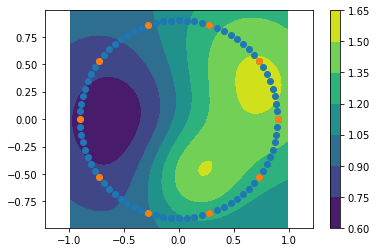

In [215]:
plt.axis('equal')
plt.contourf(X,Y,cost); plt.colorbar();
plt.scatter(*receivers);
plt.scatter(*sources);

In [216]:
hfmIn.update({
    'cost':cost_truth,
    'seeds':[sources[:,0]],
    'tips':receivers.T
})

In [217]:
hfmOut = hfmIn.RunSmart()

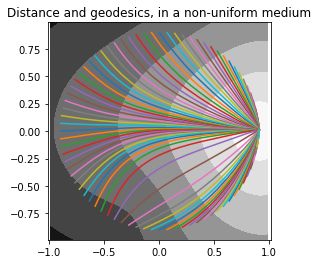

In [218]:
plt.figure(figsize=[4,4]); plt.title('Distance and geodesics, in a non-uniform medium');  plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values'],cmap='Greys') # Display the value function. 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

The traveltimes obtained with various sources gather information over all the domain data.
The purpose of seismic tomography is compute the medium properties from the traveltimes, instead of the converse done here.

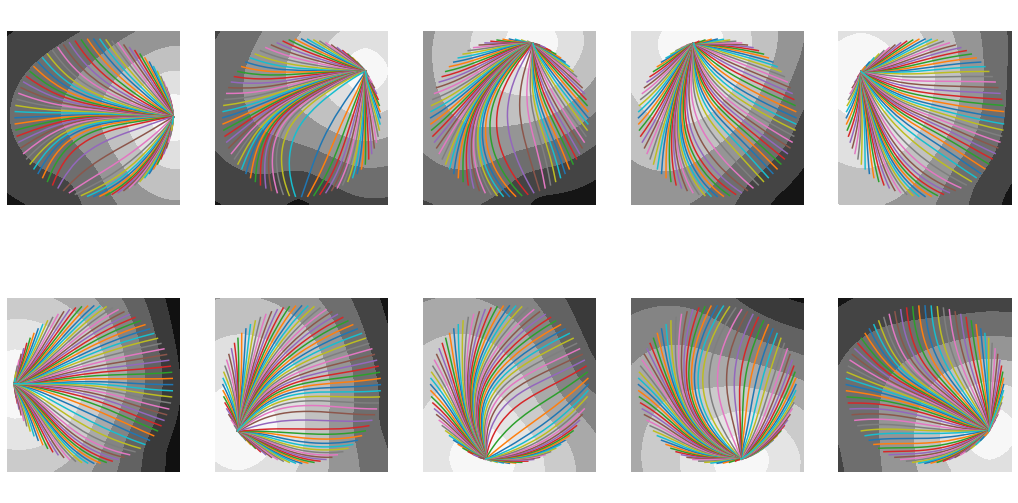

In [219]:
plt.figure(figsize=[18,9]); 
for i,source in enumerate(sources.T):
    hfmIn['seeds']=[source]
    hfmOut = hfmIn.RunSmart()
    plt.subplot(2,5,1+i)
    plt.axis('equal'); plt.axis('off')
    plt.contourf(X,Y,hfmOut['values'],cmap='Greys') 
    for geo in hfmOut['geodesics']:  plt.plot(*geo) 

**TODO** Use shooting, or add perturbations, etc ... to avoid self-confirmation biais. (Solving an inverse problem with simulated data based on the same solver.)


In [262]:
traveltimes_target = traveltimes(cost,sources,copy(hfmIn))

## 2. Optimized functional



In [282]:
def traveltimes(cost,sources,hfmIn,rev=None):
    times = []
    hfmIn = copy(hfmIn)
    hfmIn['extractValues']=True
    hfmIn['cost']=cost
    hfmIn.pop('tips',None)
    
    for source in sources.T:
        hfmIn['seeds'] = [source]
        if rev is None: _,values = hfmIn.RunSmart() 
        else: _,values = rev.apply(HFMUtils.RunSmart,copy(hfmIn)) 
        interp = fd.UniformGridInterpolator(grid,values)
        times.append(interp(*receivers))
        
    return ad.array(times)

The optimized functional needs to feature:
* A data fidelity term, ensuring that the computed travel times are close to the target travel times.
* A regularization term.

In [222]:
def sqL2(arr):
    """squared normalized l2 norm"""
    return (arr**2/arr.size).sum()

def loss(cost,traveltimes,epsL2=0.1):
    """loss function for tomography"""
    return sqL2(traveltimes-target_traveltimes) + epsL2**2*sqL2(cost-1)

In [226]:
"""
def tomography_objective(cost_,co_output=None,*args,**kwargs):    
    # Generate an operator-like AD environnement
    rev,cost = ad.Reverse.operator_like(inputs=cost_,co_output=co_output,
                                        input_iterables=(dict,))
    traveltimes = []
    hfmIn['extractValues']=True
    hfmIn['cost']=cost
    for source in sources.T: #[[5]]:
        hfmIn['seeds'] = [source]
        _,values = rev.apply(HFMUtils.RunSmart,hfmIn)
        interp = fd.UniformGridInterpolator(grid,values)
        traveltimes.append(interp(*receivers)) #[:,[20]]

    traveltimes = ad.array(traveltimes)
    objective = loss(cost,traveltimes,*args,**kwargs)

    return rev.output(objective)
"""

In [227]:
sources.T[[0]].shape

(1, 2)

In [228]:
tomography_objective(cost_truth,epsL2=0.)

0.0

In [231]:
cost_guess = np.ones(cost_truth.shape)
tomography_objective(cost_guess)

0.08103888498077169

## 3. Forward differentiation

Recover the weights of the bumps.

In [270]:
deltas = ad.Dense.identity((3,))
bumps_fwd = sum(delta*bump for (delta,bump) in zip(deltas,cost_bumps))

Forward differentiation has no impact on the zero-th order term.

In [272]:
difftimes = traveltimes(cost_truth+bumps_fwd,sources,hfmIn) - traveltimes_target
assert norm_infinity(difftimes.value) < 1e-15

In [286]:
difftimes_fwd = traveltimes(cost_guess+bumps_fwd,sources,hfmIn) - traveltimes_target

In [276]:
sqL2(difftimes_fwd)

denseAD(array(0.08103888),array([-0.1054134 , -0.03929969, -0.16265291]))

In [277]:
cost_heights

[1.5, -0.9, 0.3]

## 4. Reverse differentiation

Adjoint based tomography

TODO : cross check with forward differentiation.

In [291]:
rev,cost_guess_rev = ad.Reverse.empty(inputs=cost_guess,input_iterables=(dict,))
difftimes_rev = traveltimes(cost_guess_rev,sources,hfmIn,rev=rev) - traveltimes_target
assert norm_infinity(difftimes_rev.value-difftimes_fwd.value)<1e-15

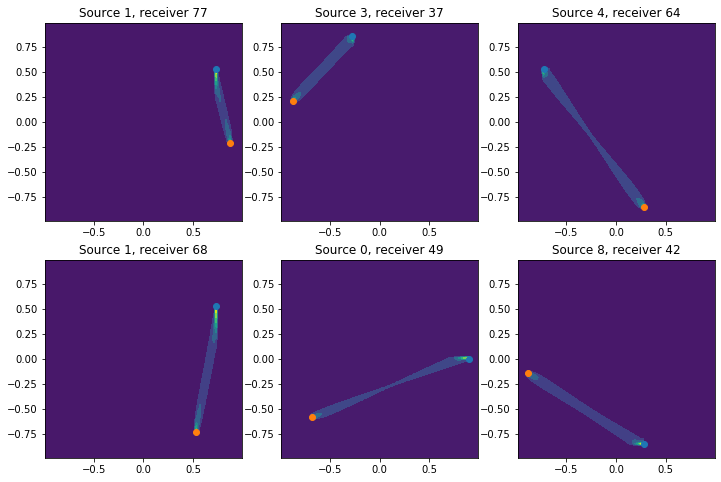

In [303]:
plt.figure(figsize=[12,8])
for i in range(6):
    i_source   = random.randint(0,len(sources.T)-1)
    i_receiver = random.randint(0,len(receivers.T)-1)
    grad, = rev.to_inputshapes(rev.gradient(difftimes_rev[i_source,i_receiver]))
    plt.subplot(2,3,1+i)
    plt.title(f"Source {i_source}, receiver {i_receiver}")
    plt.contourf(*grid,grad)
    plt.scatter(*sources[:,i_source])
    plt.scatter(*receivers[:,i_receiver])

Consistent with forward differentiation.

In [307]:
grad, = rev.to_inputshapes(rev.gradient(sqL2(difftimes_rev)))
[(grad*cost).sum() for cost in cost_bumps]

[-0.1054133996275406, -0.03929968673140113, -0.1626529120295601]